In [ ]:
from ceruleanml import data
from ceruleanml import evaluation
from ceruleanml import load_negative_tiles
from ceruleanml.coco_stats import get_all_record_area_lists_for_class, assemble_record_label_lists,  ignore_low_area_records
from icevision.parsers import COCOMaskParser
from icevision.data import SingleSplitSplitter
from fastai.data.block import DataBlock
from fastai.vision.data import ImageBlock, MaskBlock
from fastai.vision.augment import aug_transforms
from fastai.vision.learner import unet_learner
from fastai.data.transforms import RandomSplitter, Normalize
from fastai.metrics import Dice
from ceruleanml.coco_load_fastai import record_collection_to_record_ids, get_image_path, record_to_mask
from torchvision.models import resnet18, resnet34, resnet50
from fastai.callback.fp16 import MixedPrecision
from fastai.callback.tensorboard import TensorBoardCallback
from datetime import datetime
from pathlib import Path
import os, glob, random
from statistics import mean
from icevision.visualize import show_data
import torch

### Parsing COCO Dataset with Icevision

In [2]:
data_path = "/root/"
mount_path = "/root/data"

#### Parsing (positive) examples and filtering by area

In [3]:
class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))
train_parser = COCOMaskParser(annotations_filepath=f"{mount_path}/tile-cerulean-v2-partial-with-context/instances_Tiled Cerulean Dataset V2.json", img_dir=f"{mount_path}/tile-cerulean-v2-partial-with-context/tiled_images")
positive_train_records= train_parser.parse(autofix=False, data_splitter=SingleSplitSplitter())
# val_parser = COCOMaskParser(annotations_filepath=f"{mount_path}/partitions/val/instances_tiled_cerulean_train_v2.json", img_dir=f"{mount_path}/partitions/val/tiled_images")
# positive_val_records= val_parser.parse(autofix=False, SingleSplitSplitter())
# test_parser = COCOMaskParser(annotations_filepath=f"{mount_path}/partitions/test/instances_tiled_cerulean_train_v2.json", img_dir=f"{mount_path}/partitions/test/tiled_images")
# positive_test_records= test_parser.parse(autofix=False, SingleSplitSplitter())

  0%|          | 0/3883 [00:00<?, ?it/s]

In [4]:
import pandas as pd
class_names = ['infra_slick', 'natural_seep', 'coincident_vessel', 'recent_vessel', 'old_vessel', 'ambiguous']
record_area_label_lists = assemble_record_label_lists(positive_train_records[0])
dfs = []
for c in class_names:
    positive_train_area_label_lists = get_all_record_area_lists_for_class(record_area_label_lists, c)
    dfs.append(pd.DataFrame(positive_train_area_label_lists,columns = ["record_id", "label", "area"]))
area_df = pd.concat(dfs)

In [5]:
# area_df.drop("record_id", axis=1).groupby("label").describe()

In [6]:
# area_df.drop("record_id", axis=1).groupby("label").quantile(.03)

#### Get list of flagged records

In [7]:
area_thresh = 10

#### Remove flagged annotations in place (note: this sets values to none but doesn't remove the record dict. is this ok? does the trainer discard these?)

In [8]:
import icevision

In [9]:
ignore_low_area_records(positive_train_records[0], area_thresh=area_thresh)

#### Parse negative tiles

In [10]:
images_available = glob.glob(f"{mount_path}/tile-cerulean-v2-partial-with-context/tiled_images/*")
record_ids = record_collection_to_record_ids(positive_train_records[0])

Note: The count argument in the line below allows you to control how many negative tiles are desired.

In [16]:
negative_train_records, negative_valid_records = load_negative_tiles.parse_negative_tiles(data_dir=f"{mount_path}/tile-cerulean-v2-partial-with-context/tiled_images", record_ids=record_ids, positive_train_records=positive_train_records[0], count=100)


  0%|          | 0/100 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/100 [00:00<?, ?it/s]

#### Combine the positive and negative parsed examples

In [17]:
combined_train_records = positive_train_records[0] + negative_train_records
# combined_valid_records = positive_valid_records[0] + negative_valid_records

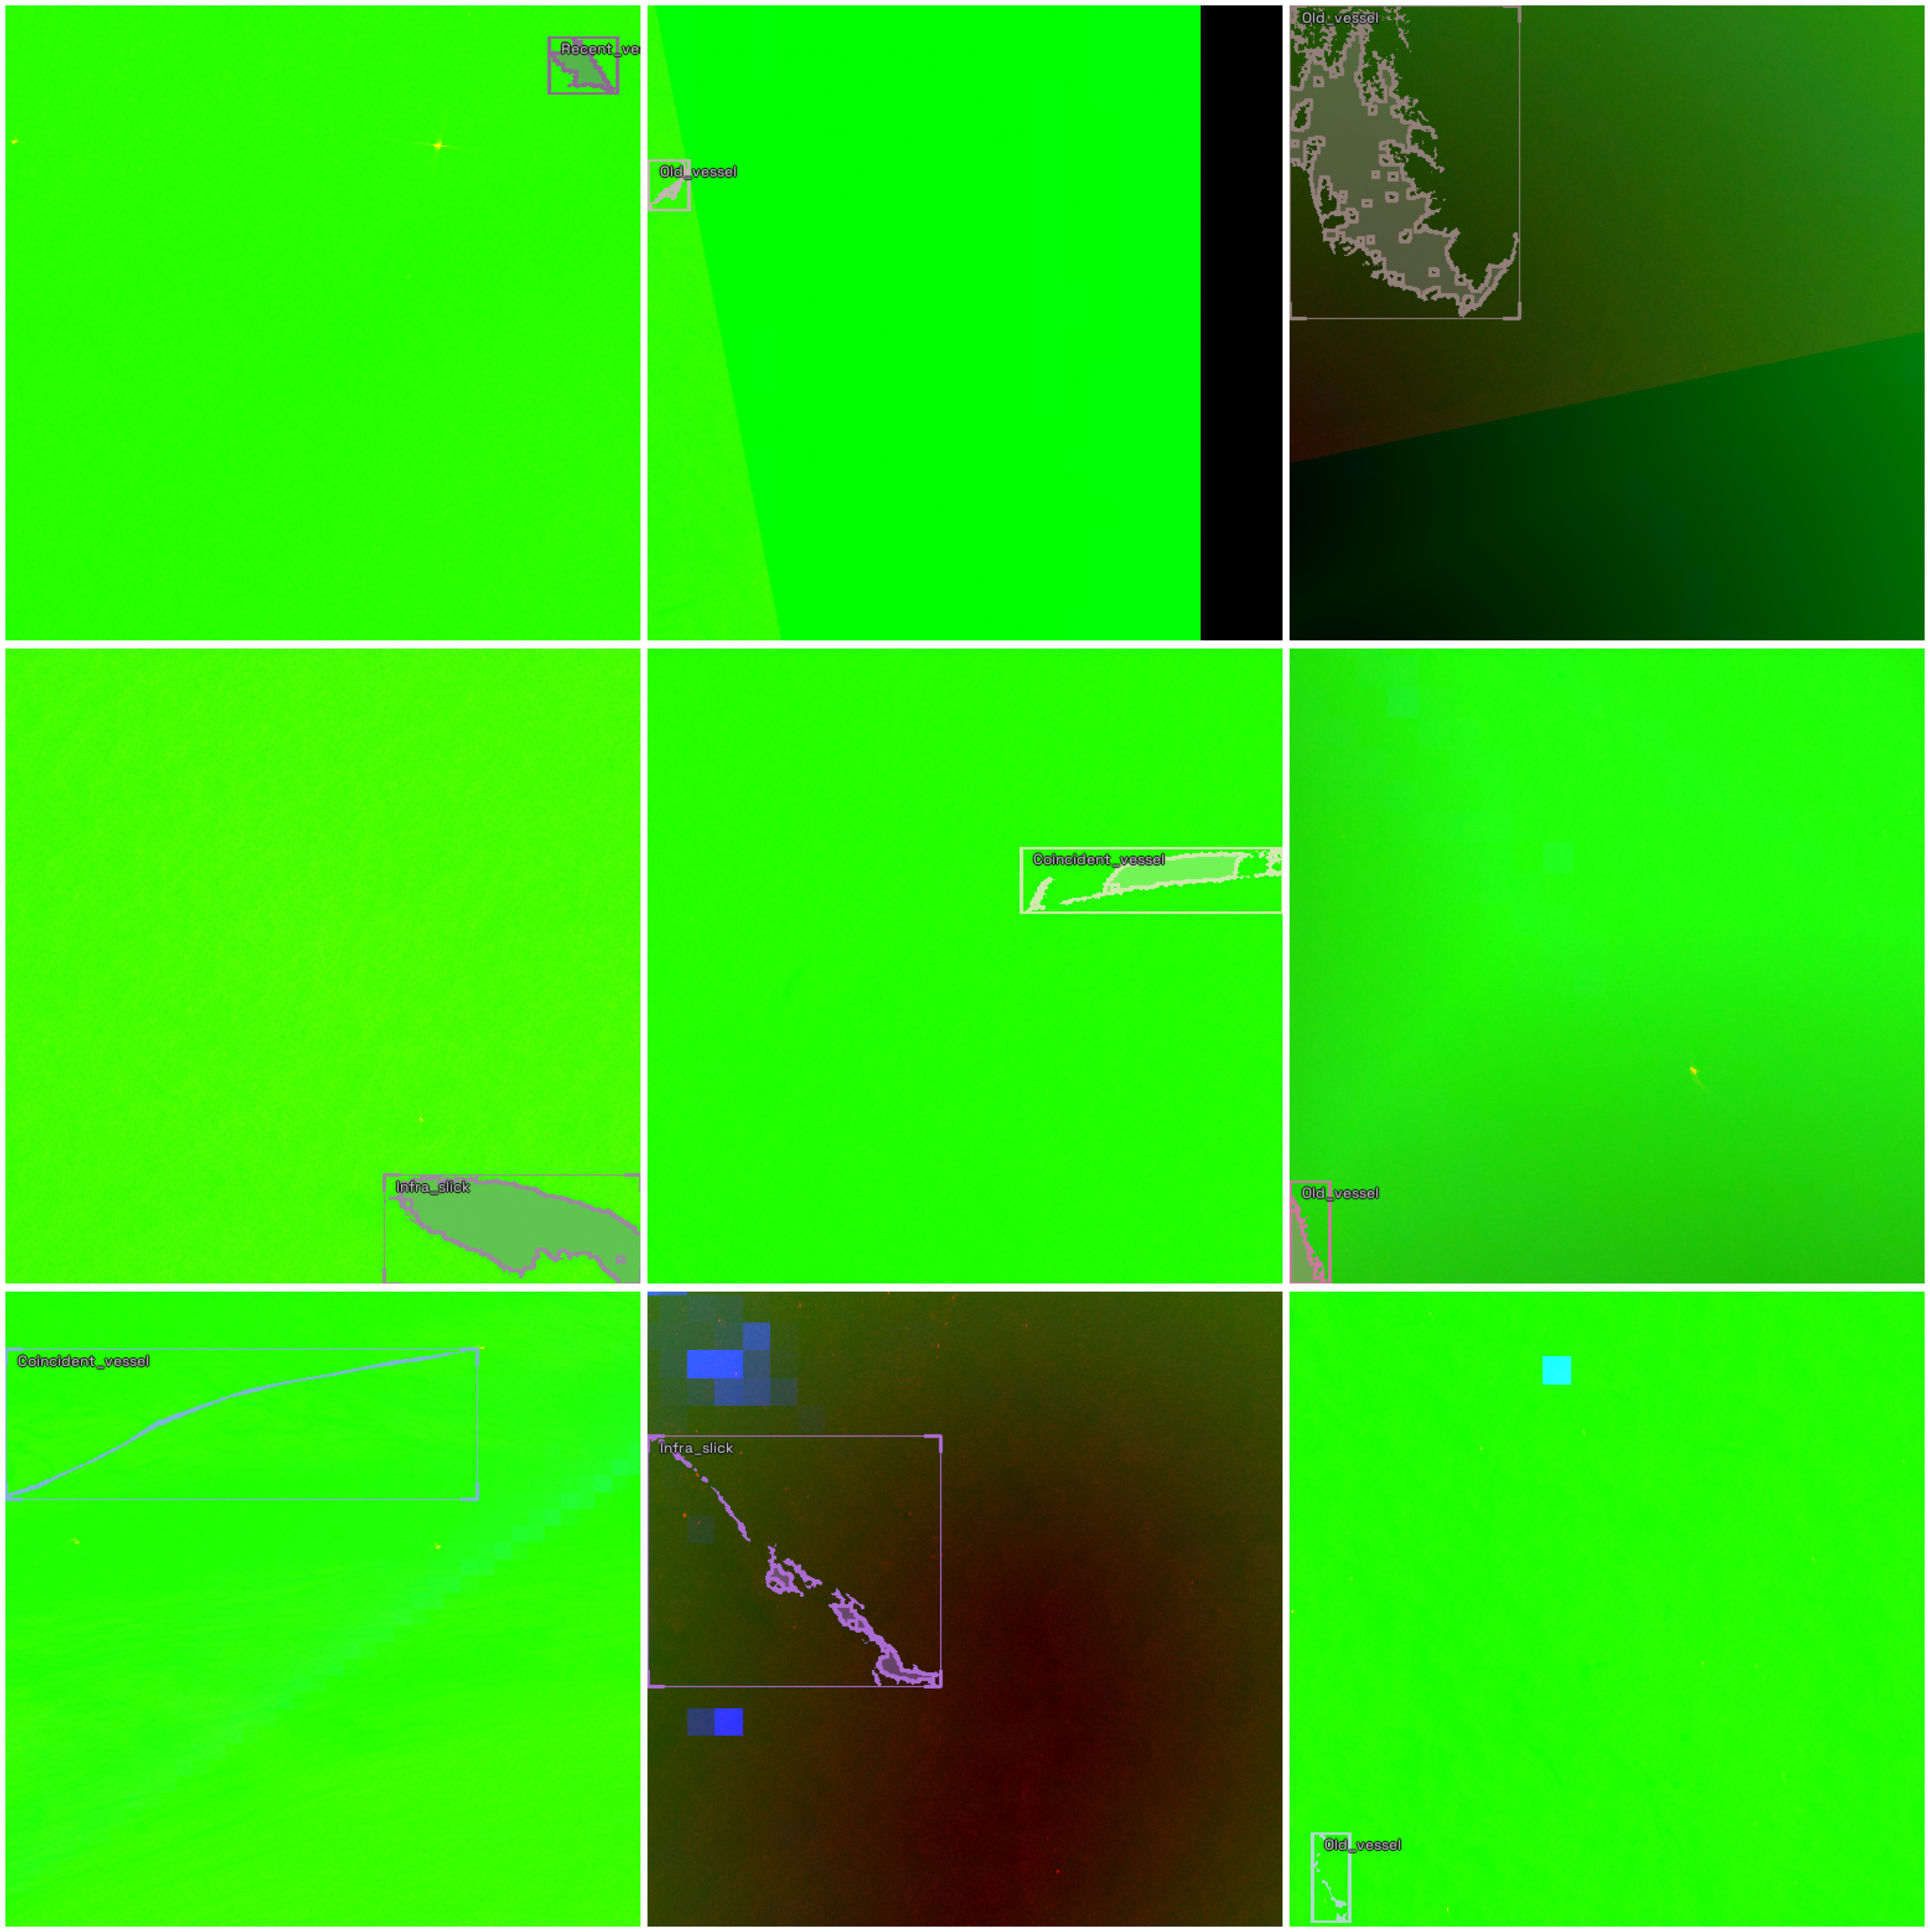

In [18]:
show_data.show_records(random.choices(combined_train_records, k=9), ncols=3)

### Constructing a FastAI DataBlock that uses parsed COCO Dataset from icevision parser and applies transformations

In [ ]:
mean = [60.73,       190.3,      4.3598]
std = [16.099,      17.846,       9.603]

In [ ]:
batch_transfms = [aug_transforms(),  Normalize.from_stats(mean,std)]

In [ ]:
def get_image_by_record_id(record_id):
    return get_image_path(positive_train_records, record_id)

def get_mask_by_record_id(record_id):
    return record_to_mask(positive_valid_records, record_id)

#size = 64  # Progressive resizing could happen here
augs = aug_transforms(flip_vert=True, max_warp=0.1) #, size=size)
coco_seg_dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=class_ints)),
    get_x=get_image_by_record_id,
    splitter=RandomSplitter(),
    get_y=get_mask_by_record_id,
    batch_tfms=[Normalize.from_stats(mean,std)],
    n_inp=1,
)

dls = coco_seg_dblock.dataloaders(source=record_ids, batch_size=1)

### Fastai2 Trainer

In [ ]:
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
experiment_dir =  Path(f'{mount_path}/experiments/cv2/'+timestampStr+'_fastai_unet/')
experiment_dir.mkdir(exist_ok=True)

In [ ]:
arch = 18
archs = {18: resnet18, 34: resnet34, 50: resnet50}

In [ ]:
learner = unet_learner(dls, archs[arch], metrics=[Dice()], model_dir=experiment_dir, n_out = 7, cbs=[MixedPrecision]) # cbs=[MixedPrecision]

#lr = learner.lr_find()

cbs = [TensorBoardCallback(projector=False, trace_model=False)]

learner.fine_tune(1, 2e-4, cbs=cbs)#, cbs=SaveModelCallback(monitor='dice'))w

In [ ]:
validation = learner.validate()

In [ ]:
size=512
savename = f'test_1batch_{arch}_{size}_{round(validation[1],3)}.pt'

In [ ]:
from ceruleanml.inference import save_fastai_model_state_dict_and_tracing, load_tracing_model, test_tracing_model_one_batch, logits_to_classes

In [ ]:
state_dict_pth, tracing_model_gpu_pth, tracing_model_cpu_pth  = save_fastai_model_state_dict_and_tracing(learner, dls, savename, experiment_dir)

In [ ]:
import torch
experiment_dir = '/root/data/experiments/cv2/24_May_2022_01_49_56_fastai_unet/'
savename = "tracing_cpu_test_1batch_18_512_0.082.pt"
tracing_model = load_tracing_model(os.path.join(experiment_dir, savename))
out_batch_logits = test_tracing_model_one_batch(dls.to('cpu'), tracing_model)

In [ ]:
conf, classes = logits_to_classes(out_batch_logits)

In [ ]:
classes.shape

In [ ]:
conf.shape

In [ ]:
learn.show_results(max_n=4, figsize=(20,20), vmin=0, vmax=3)

Default path for tensorboard logs is `./runs/`

In [ ]:
f'{mount_path}/experiments/cv2/'

In [ ]:
!ls '/root/data/experiments/cv2/20_May_2022_19_29_39_fastai_unet'

In [ ]:
!ls './runs/'

Copy logs to appropriate exeriments folder in the mounted GCS volume.

In [ ]:
!cp -R './runs/' {modelpath}'/tensorboard/'

Now, run the following from anywhere with gcs authenticated:

In [ ]:
!tensorboard --logdir="./runs"


# Model Inference and Result Evaluation

In [ ]:
val_record_ids = record_collection_to_record_ids(valid_records)
pred_arrs = []
val_arrs = []
with learn.no_logging():
    for v, i in zip(range(len(val_record_ids[0:10])), val_record_ids[0:10]):
        v = valid_records[v].as_dict()
        v_masks = v['detection']['masks'][0].to_mask(v['common']['height'],v['common']['width']).data
        p = get_image_path(valid_records,i)
        arr = skio.imread(p)
        pred_arr = learn.predict(arr)
        pred_arr = pred_arr[0].cpu().detach().numpy()
        pred_arrs.append(pred_arr)
        val_arrs.append(v_masks)

In [ ]:
cm, f1 = eval.cm_f1(val_arrs, pred_arrs, 6, mount_path)

In [ ]:
learner = torch.load("/root/data/experiments/cv2/10_May_2022_18_02_59_fastai_unet/18_64_0.493.pkl")

In [ ]:
learner.predict??

In [ ]:
import skimage.io as skio
val_record_ids = record_collection_to_record_ids(valid_records)
pred_arrs = []
with learner.no_logging():
    for i in val_record_ids:
        p = get_image_path(valid_records,i)
        arr = skio.imread(p)
        pred_arr = learner.predict(arr)
        pred_arrs.append(pred_arr)

In [ ]:
# this results in vm dying, not just kernel crash
# coco_seg_dblock = DataBlock(
#     blocks=(ImageBlock, MaskBlock(codes=class_ints)),
#     get_x=get_image_by_record_id,
#     get_y=get_mask_by_record_id,
#     n_inp=1,
# )

# dls = coco_seg_dblock.dataloaders(source=record_ids, batch_size=5)


In [ ]:
result = learner.get_preds(dl=dls[0])

In [ ]:
learner.get_preds??

In [ ]:
len(pred_arrs)

In [ ]:
target_label,prediction_arr, activations = pred_arrs[0]

In [ ]:
skio.imshow(target_label.cpu().detach().numpy())

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[0])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[1])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[1])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy())

In [ ]:
array([      60.73,       190.3,      4.3598]) # means
array([     16.099,      17.846,       9.603]) # stats